# 1  Automated data cleaning for chest Xrays with cleanX: notebook for medical professionals with limited coding abililties. 

CleanX is a code library by Candace Makeda Moore, MD, Oleg Sivokon, and Andrew Murphy. Please note this workflow does not cover the whole scope of cleanX, and is only meant to show some of the functionality that can be accomplished using cleanX. 

The purpose of this notebook is to educate people with very limited understanding of machine learning and code about some of what cleanX does, and why it is worth incorporating it into use. 

In [ ]:
import sys
sys.path = ['D:/projects/cleanX'] + sys.path
# we will need to import some libraries
import pandas as pd
import os
from cleanX import (
    dataset_processing as csvp,
    dicom_processing as dicomp,
    image_work as iwork,
)

Reading and analysis of chest X-rays is a common task in hospitals. In fact in many hospitals so many chest X-rays are performed that some are never read, and some are only read by people with limited training in radiology. Some countries have a very limited number of radiologists so radiographers read the chest X-rays. Regardless of who reads these images, they can be difficult to interpret and the error rate is reported as high in the medical literature (over 10% or even over 15% depending upon the source). Machine learning based algorithms have the potential to improve this situation in a variety of ways, however machine learning algorithms are powered by mountains of labeled data. And this need for labeled data creates a potential problem. 

Labeled data must either be retrieved from existing read X-rays (errors included), or created by humans (already over-burdened with reading X-rays, actually that was the original problem in the first place, right?). Several groups have created big datasets that algorithms can be trained on, but no dataset is perfect for every task. Unfortunately many datasets contain images that may not be appropriate to make a machine learning algorithm from. As a case in point, let's take a look at some of the data in a large set of COVID-19 images. We will use the CoronaHack -Chest X-Ray-Dataset from Kaggle. The dataset was assembled by Praveen Govindaraj. This dataset has thousands of images...too many to look through by hand without wasting a lot of time

In [ ]:
origin_folder ='D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'

## A word on finding duplicates
We may or may not want to use duplicated images to build an algorithm. Generally, it's a bad idea. At the extreme, if all of one pathology is simply duplicated images, we do not have enough data. Instead of trying to remember if we see duplicates in thousands of images, let's ask cleanX. cleanX compares the images pixel by pixel, and this takes time if you don't have a powerful computer, but it doesn't take human time. We can take a much needed break! 

In [ ]:
found = iwork.find_duplicated_images_todf(origin_folder)
len(found[found.status == 'duplicated'])  

OK, so we may have 26 duplicates. Not so bad out of thousands of pictures. Let's pull up a list so we can check them by hand.

In [ ]:
found[found.status == 'duplicated']

In [ ]:
wierd_images = found[found.status == 'duplicated']
wierd_images_list = wierd_images.images.to_list()

# we need the full file path
final_names = []
for image_string in wierd_images_list:
    final_names.append(os.path.join(origin_folder, image_string))

In [ ]:
iwork.show_images_in_df(final_names,19)

In [ ]:
# make a function that compares one image to list, and finds closest. 
import cv2
import numpy as np
image1 = 'person1372_bacteria_3502.jpeg'
image1name = os.path.join(origin_folder, image1)
compare_list = final_names
image1image = cv2.imread(image1name)
results = []
pictures = []
width, height = image1image.shape[1], image1image.shape[0]
dim = (width, height)
for picture in compare_list:
    
    image_there = cv2.imread(picture)
    resized = cv2.resize(image_there, dim, interpolation = cv2.INTER_AREA)
    result = resized - image1image
    result_sum = np.sum(result)
    results.append(result_sum)
    pictures.append(pictures)

In [ ]:
d = {'results':results,'pictures':pictures}
ho = pd.DataFrame(d)

In [ ]:
ho

Interesting, some of our duplicated pictures appear to have been triplicated, and we get two of the same duplicate.

## Let's look a different way

In [ ]:
# def create_compressed_imgs_array(directory):
#     """
#     This is a helper function to be used inside another function.
#     It makes a big arrays of compressed image arrays
#     """
#     compression=50
#     global image_files   
#     image_files = []
#     # create list of all files in directory     
#     folder_files = [filename for filename in os.listdir(directory)]  
#     # create images array  
#     counter = 0
#     for filename in folder_files: 
#         img = cv2.imread(directory + filename)
#         if type(img) == np.ndarray:
#             img = img[...,0:3]
#             # resize the image based to compression value (40)
#             img = cv2.resize(img, dsize=(compression, compression), interpolation=cv2.INTER_CUBIC)
#             if counter == 0:
#                 imgs_array = img
#                 image_files.append(filename)
#                 counter += 1
#             else:
#                 imgs_array = np.concatenate((imgs_array, img))
#                 image_files.append(filename)
#     return imgs_array

In [ ]:
#print(type(create_imgs_array('D:/my_academia/new_dicom_output/')))

In [ ]:
# def add_to_list(filename, list):
#     list.append(filename)

In [68]:
def show_close_images(folder, compression_level,ref_mse):
    """
    This function shows potentially duplicated images by
    comparing compressed versions of the images.
    :param folder: folder with jpgs
    :type folder: string
    :param ref_mse: mse is a mean squared error
    :type ref_mse: float

    :return: near_dupers
    :rtype: pandas.core.frame.DataFrame
    """
    compression = compression_level
    # lists of the found duplicate/similar images 
    duplicates_A = []
    duplicates_B = []
    image_files = []
    # list of all files in directory  
    suspects1 = glob.glob(os.path.join(folder, '*.[Jj][Pp][Gg]'))
    suspects2 = glob.glob(os.path.join(folder, '*.[Jj][Pp][Ee][Gg]'))
    folder_files = suspects1 + suspects2

    # create images array  
    counter = 0
    for filename in folder_files: 
        img = cv2.imread(filename)
        if type(img) == np.ndarray:
            img = img[...,0:3]
            # resize the image based to compression value (40)
            img = cv2.resize(img, dsize=(compression, compression), interpolation=cv2.INTER_CUBIC)
            if counter == 0:
                imgs_array = img
                image_files.append(filename)
                counter += 1
            else:
                imgs_array = np.concatenate((imgs_array, img))
                image_files.append(filename)
    # cook it            
    main_img = 0
    compared_img = 1
    nrows, ncols = compression, compression
    srow_A = 0
    erow_A = nrows
    srow_B = erow_A
    erow_B = srow_B + nrows       
    while erow_B <= imgs_array.shape[0]:
        while compared_img < (len(image_files)):
            # select two images from imgs_matrix
            imgA = imgs_array[srow_A : erow_A, # rows
                               0      : ncols]  # columns
            imgB = imgs_array[srow_B : erow_B, # rows
                               0      : ncols]  # columns
            # compare the images
            err = np.sum((imgA.astype("float") - imgB.astype("float")) ** 2)
            err /= float(imgA.shape[0] * imgA.shape[1])
            if err < ref_mse:
                fig = plt.figure()
                plt.suptitle("MSE: %.3f" % (err))
                # plot first image
                ax = fig.add_subplot(1, 2, 1)
                plt.imshow(imgA, cmap = plt.cm.gray)
                plt.axis("off")
                # plot second image
                ax = fig.add_subplot(1, 2, 2)
                plt.imshow(imgB, cmap = plt.cm.gray)
                plt.axis("off")
                # show the images
                plt.show()
                print("Similar files: " + image_files[main_img] + " and " + image_files[compared_img])
                duplicates_A.append(image_files[main_img])
                duplicates_B.append(image_files[compared_img])
                dupers = {'twinA?':duplicates_A,'twinB?' :duplicates_B}
                near_dupers = pd.DataFrame(dupers)
                near_dupers['mse'] = err
            srow_B += nrows
            erow_B += nrows
            compared_img += 1
        
        srow_A += nrows
        erow_A += nrows
        srow_B = erow_A
        erow_B = srow_B + nrows
        main_img += 1
        compared_img = main_img + 1

    print("\n***\n Output: ",
           str(len(duplicates_A)),
           " potential duplicate image pairs in ",
           str(len(image_files)), 
           " total images.\n",
           "At compression level",
            compression,
            "and mse",
             ref_mse,
    )
    return near_dupers
    

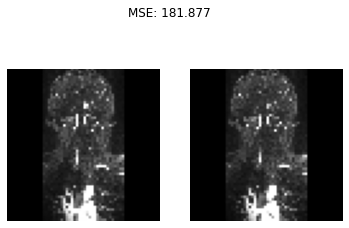

Similar files: D:/my_academia/new_dicom_output\IM-0001-0074.dcmfe2f32c2-0564-45a2-9aa7-6c71c6a6913d.dcm.jpg and D:/my_academia/new_dicom_output\IM-0001-0075.dcmfaf20448-a0ee-46ff-9d3e-f0280bbefcce.dcm.jpg


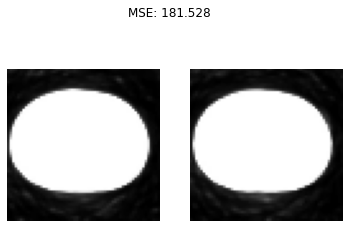

Similar files: D:/my_academia/new_dicom_output\IM-0001-0075.dcm3a5738c1-6dfb-4fc0-b038-3f46ad7dcc5b.dcm.jpg and D:/my_academia/new_dicom_output\IM-0001-0076.dcm9d5a9a20-2bf3-4de1-84a1-ea625537f2bc.dcm.jpg

***
 Output:  2  potential duplicate image pairs in  12  total images.
 At compression level 60 and mse 190


,twinA?,twinB?,mse
0,D:/my_academia/new_dicom_output\IM-0001-0074.d...,D:/my_academia/new_dicom_output\IM-0001-0075.d...,181.528333
1,D:/my_academia/new_dicom_output\IM-0001-0075.d...,D:/my_academia/new_dicom_output\IM-0001-0076.d...,181.528333


In [70]:

show_close_images('D:/my_academia/new_dicom_output/',60,190)

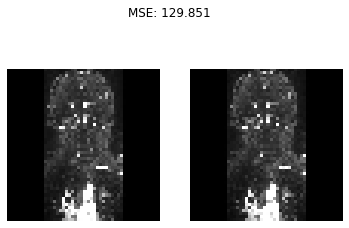

Similar files: D:/my_academia/new_dicom_output\IM-0001-0074.dcmfe2f32c2-0564-45a2-9aa7-6c71c6a6913d.dcm.jpg and D:/my_academia/new_dicom_output\IM-0001-0075.dcmfaf20448-a0ee-46ff-9d3e-f0280bbefcce.dcm.jpg

***
 Output: 1 potential duplicate image pairs in 12 total images.

<class 'pandas.core.frame.DataFrame'>


In [51]:
shown = show_close_images(diro,140)
print(type(shown))

In [ ]:
shown

In [ ]:
target_upside_down1+'/'